# Support vector machines

### Kyle Willett
#### 28 Jul 2016

Support vector machines are a general class of supervised learning models. They can be used for at least three different basic tasks in ML:

* classification (assigning a label to data)
* regression (predicting a continuous value associated with data)
* detecting outliers

In the first two cases, SVMs compete with many other machine learning techniques that have a range of implementations. Here are some reasons why an SVM might be an appropriate tool for a problem:

* The core of SVM lies in finding the extremum (usually the maximum) of the margin for the separating hyperplane. Since there is a particular value associated with that, it can be more robust than simple regression. 
* SVM is not limited to simple boundaries like those used in linear regression. 
* SVM uses the *kernel trick*, which maps input features into high-dimensional spaces with relatively low computational costs. This allows a variety of different kernels to be implemented. 
* A subset of the data (the support vectors themselves) are ultimately used as the predictor, so the technique can be more memory-efficient compared to (kernel) logistic regression. 
* Several parameters can be tuned to adjust for overfitting, including the cost $C$ and kernel parameters (type, $\sigma,\gamma$, etc).
* SVM is by definition a convex optimization problem, so optimizing the margin does not risk being caught in local minima. The solution is thus always unique.
* *Anecdotally*, SVM has given slightly better performance than regression in many real-world problems (eg, solvency analysis of Auria & Moro 2008).

Reasons against using SVMs:

* Linear (if applicable) or logistic regression can often provide comparable performance. 
* If $N_{features}\gg N_{samples}$, the margin will be strongly set by the high-dimensional spaces where there will be fewer support vectors, and so performance may suffer. (*It's not clear what better methods exist in that case.*)
* Probability estimates come from $k$-fold cross-validation in scikit-learn, which is computationally expensive. 
* Doesn't work with categorical data unless one-hot encoded. 

In [7]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn import preprocessing, svm
from sklearn.cross_validation import train_test_split

In [3]:
# Try it out with some data; start with Titanic survivors.

titanic = pd.read_csv("../dc/titanic_train.csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [6]:
# Encode the categorical variables

# Sex (binary)
le_Sex = preprocessing.LabelEncoder()
le_Sex.fit(list(set(titanic.Sex)))
titanic['Sex_int'] = le_Sex.transform(titanic.Sex)

# Embarked (three sets)
embarked_filled = titanic.Embarked.fillna("N")
le_Embarked = preprocessing.LabelEncoder()
le_Embarked.fit(list(set(embarked_filled)))
titanic['Embarked_int'] = le_Embarked.transform(embarked_filled)

# Since there are still NaNs in the frame, impute missing values

tvar = ['Pclass', u'Sex_int', u'Age', u'SibSp', u'Parch',
       u'Fare', u'Embarked_int']

imp = preprocessing.Imputer(missing_values="NaN",strategy="mean")
imp.fit(titanic[tvar])
imputed = imp.transform(titanic[tvar])

In [19]:
titanic['Survived'].values.shape

(891,)

In [22]:
# Split into test and training data

X = imputed
y = titanic['Survived'].values

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.70,random_state=51)

In [25]:
# Load the SVM classifier

clf = svm.SVC(kernel='linear',C=1.0)
clf.fit(X_train,y_train);

In [32]:
clf.score(X_test,y_test)

0.77985074626865669

In [36]:
y_score = clf.decision_function(X_test)

(268,) (268,)


In [49]:
from sklearn.metrics import roc_curve,auc

fpr, tpr, thresholds = roc_curve(y_test,y_score)
roc_auc = auc(fpr,tpr)

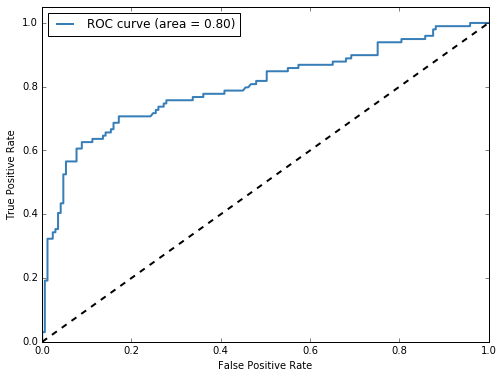

In [50]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc="best");

Not great. $AUC=0.80$ could be much better, although it's a significant improvement over random.

In [56]:
print "This result used {} support vectors from the {}-sized training sample.".format(
    clf.support_vectors_.shape[0],X_train.shape[0])

This result used 276 support vectors from the 623-sized training sample.
